In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import glob
import uuid
import random
import platform
import ecgdetectors
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import lognorm, norm, halfnorm

import src.data
import utils
import utils
import utils.visualization
import utils.visualization.plot
import utils.wavelet
import utils.data
import utils.data.augmentation
import utils.visualization
import utils.visualization.plot
import utils.torch
import utils.torch.nn
import utils.torch.nn as nn
import utils.torch.loss
import utils.torch.train
import utils.torch.data
import utils.torch.preprocessing
import utils.torch.models
import utils.torch.models.lego
import utils.torch.models.variational
import utils.torch.models.classification

from utils.signal import StandardHeader

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def moving_amplitude(x, w):
    return [np.max(x[i:i+w])-np.min(x[i:i+w]) for i in range(0,len(x),w)]

def moving_operation(x, w, operation):
    return [operation(x[i:i+w]) for i in range(0,len(x),w)]

def predict_mask(signal, N, stride, model,total_samples):
    # Data structure for computing the segmentation
    windowed_signal = np.array([(skimage.util.view_as_windows((signal)[:,lead],N,stride)) for lead in range(signal.shape[1])])[:,:,None,:]
    windowed_sample = np.array((skimage.util.view_as_windows(np.arange(signal.shape[0]),N,stride)))

    segmentation = np.zeros((3,signal.shape[0]),dtype=int)
    samples_voting = np.zeros((signal.shape[0],),dtype=int)

    # Compute segmentation for all leads independently
    for lead in range(windowed_signal.shape[0]):
        for i in range(0,windowed_signal.shape[1]):
            prediction = predict_segment(model,windowed_signal[lead,i,None,...]) > thr_dice

            # Fused segmentation
            segmentation[:,windowed_sample[i]] += prediction
            samples_voting[windowed_sample[i]] += 1

    # Keep track of number of samples predicted
    total_samples += samples_voting.sum()

    # Majority voting according to number of times windowed and computed
    segmentation = (segmentation > (samples_voting*ptg_voting).astype(int))
    
    return segmentation

def predict_segment(model, input):
    return model(torch.tensor(input).cuda().float())[0].cpu().detach().numpy().squeeze()

In [3]:
basedir = '/home/guille/DADES/DADES/RubenDoste/PVCVTECGData/'
fs = 2000.

In [8]:
# # Check different codes
# files = []

# for file in tqdm.tqdm(glob.glob(os.path.join(basedir,'*.csv'))):
#     signal = pd.read_csv(file)
#     aghfkjhj

  0%|          | 0/334 [00:00<?, ?it/s]


NameError: name 'aghfkjhj' is not defined

In [4]:
with open('/home/guille/GitHub/DelineatorSwitchAndCompose/configurations/UNet5Levels.json', 'r') as f:
    execution = json.load(f)

# Define model
model = torch.load('/home/guille/GitHub/DelineatorSwitchAndCompose/Notebooks/modelo5nivsdice.state').eval().float()

/home/guille/VirtEnv/DeepLearning3/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/guille/VirtEnv/DeepLearning3/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LeakyReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/guille/VirtEnv/DeepLearning3/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrie

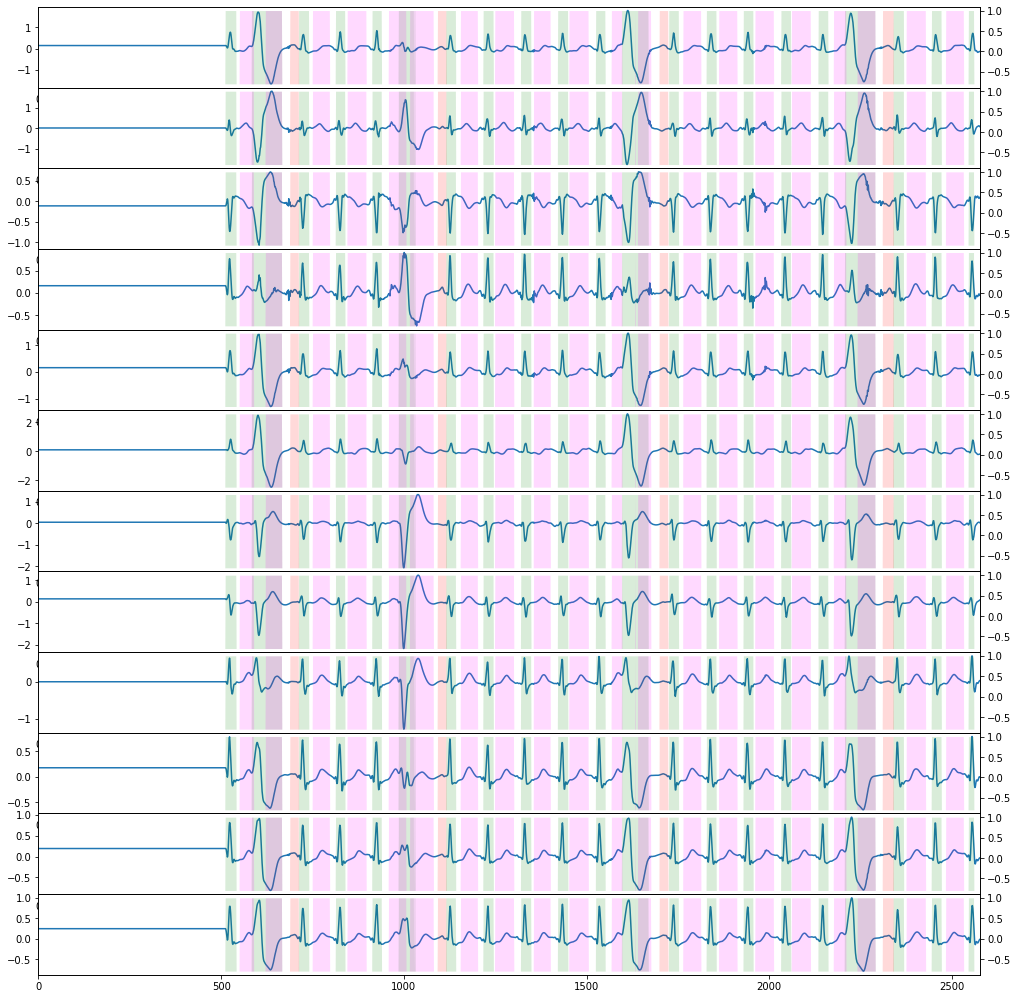

In [5]:
# signal = pd.read_csv(os.path.join(basedir,'970213.csv'))
signal = pd.read_csv('/media/guille/DADES/DADES/RubenDoste/PVCVTECGData/1009731.csv')

N = 2048
stride = 128
thr_dice = 0.8
ptg_voting = 0.25
total_samples = np.zeros((1,),dtype='int64')

# Downsample signal
down_factor = int(fs//250)
signal = sp.signal.decimate(signal,down_factor,axis=0)

# Compute moving operation for matching amplitude criteria to development set
ampl = np.median(moving_operation(signal,200,lambda x: np.max(x,axis=0)-np.min(x,axis=0)),axis=0)

signal = np.pad(signal,((512,0),(0,0)),mode='edge')
if signal.shape[0] < N:
    signal = np.pad(signal,((0,N-signal.shape[0]),(0,0)),mode='edge')
    
# Correct amplitudes
signal = signal/ampl

# Obtain segmentation
segmentation = predict_mask(signal,N,stride,model,total_samples)

# Visualization
mskplt = np.zeros_like(segmentation).astype(float)

seg = segmentation

for i in range(len(StandardHeader)):
    if seg.shape[0] != 12:
        mskplt[:,:] = ((np.max(signal[:,i])-np.min(signal[:,i])).T*seg[:,:])+np.min(signal[:,i])
    else:
        mskplt[:,:] = ((np.max(signal[:,i])-np.min(signal[:,i])).T*seg[i,:,:])+np.min(signal[:,i])

L = signal.shape[1]
f,ax=plt.subplots(nrows=L,figsize=(14,14))
[ax[i].plot(signal[:,i]) for i in range(L)]
[ax[i].set_xlim([0,signal.shape[0]]) for i in range(L)]
ax2 = [ax[i].twinx() for i in range(L)]
[ax2[i].fill_between(np.arange(signal.shape[0]), mskplt[0,:], mskplt[0,:].min(), linewidth=0, alpha=0.15, color='red') for i in range(L)]
[ax2[i].fill_between(np.arange(signal.shape[0]), mskplt[1,:], mskplt[1,:].min(), linewidth=0, alpha=0.15, color='green') for i in range(L)]
[ax2[i].fill_between(np.arange(signal.shape[0]), mskplt[2,:], mskplt[2,:].min(), linewidth=0, alpha=0.15, color='magenta') for i in range(L)]
f.tight_layout()
f.subplots_adjust(hspace=0.00,wspace=0.05)
plt.show()

In [6]:
segmentation.shape

(3, 2577)

In [ ]:
utils.get_mask_boundary()